<a href="https://colab.research.google.com/github/Flychuban/Plant_Leaf_Disease_Classification/blob/main/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from math import floor, ceil

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS= 100

In [3]:
# Load data
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/PlantDiseaseClassification/data", shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 484 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
num_classes = len(class_names)
num_classes

3

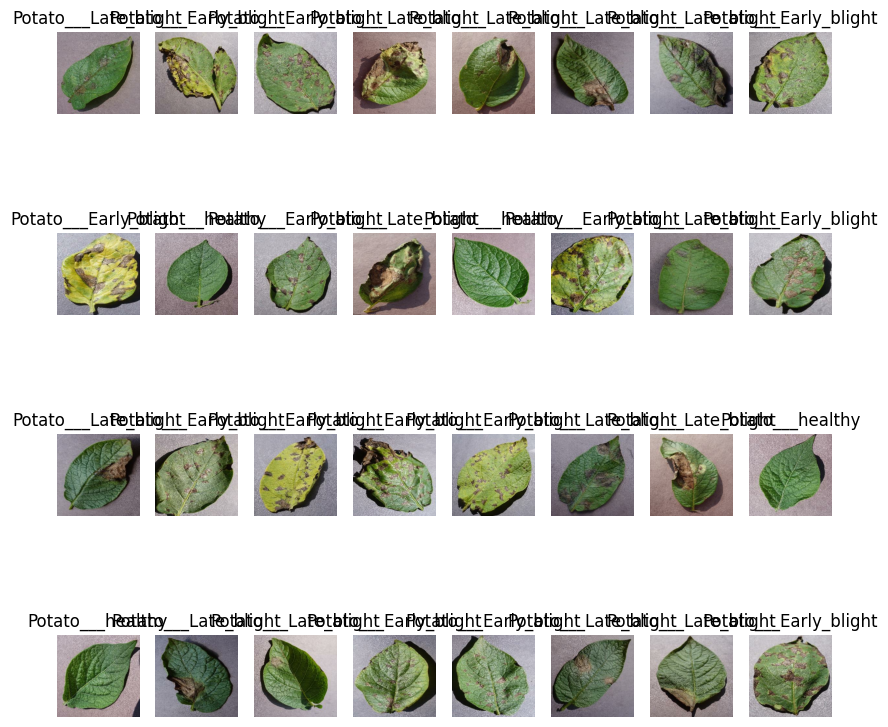

In [5]:
# Plot batch of images
for image_batch, label_batch in dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i].numpy()])
    plt.axis('off')

Train Val Test split

In [6]:
train_data = dataset.take(floor(len(dataset) * 0.8))
val_data = dataset.skip(floor(len(dataset) * 0.8)).take(ceil(len(dataset) * 0.1))
test_data = dataset.skip(floor(len(dataset) * 0.8)).skip(ceil(len(dataset) * 0.1)).take(ceil(len(dataset) * 0.1))

Preprocess data

In [7]:
train_data = train_data.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

Data augumentation to make more data

In [9]:
data_aug = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
from keras.src.layers.serialization import activation
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3) # 3 for num channels

model = Sequential([
    resize_and_rescale,
    data_aug,
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [12]:
from keras.src import metrics
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# Model training
history = model.fit(train_data, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=val_data)

Epoch 1/100
12/12 [==============================] - 1s 69ms/step - loss: 0.2176 - accuracy: 0.9375 - val_loss: 0.1201 - val_accuracy: 0.9531
Epoch 2/100
12/12 [==============================] - 1s 63ms/step - loss: 0.1514 - accuracy: 0.9531 - val_loss: 0.1532 - val_accuracy: 0.9062
Epoch 3/100
12/12 [==============================] - 1s 64ms/step - loss: 0.1675 - accuracy: 0.9583 - val_loss: 0.1602 - val_accuracy: 0.9375
Epoch 4/100
12/12 [==============================] - 1s 64ms/step - loss: 0.2912 - accuracy: 0.9245 - val_loss: 0.2625 - val_accuracy: 0.8750
Epoch 5/100
12/12 [==============================] - 1s 64ms/step - loss: 0.2109 - accuracy: 0.9323 - val_loss: 0.1796 - val_accuracy: 0.8906
Epoch 6/100
12/12 [==============================] - 1s 61ms/step - loss: 0.1712 - accuracy: 0.9297 - val_loss: 0.1522 - val_accuracy: 0.9375
Epoch 7/100
12/12 [==============================] - 1s 60ms/step - loss: 0.1829 - accuracy: 0.9427 - val_loss: 0.0956 - val_accuracy: 0.9531
Epoch 

In [23]:
# Test the model
scores = model.evaluate(test_data)

2/2 [==============================] - 0s 26ms/step - loss: 0.0484 - accuracy: 1.0000


Plot training callbacks

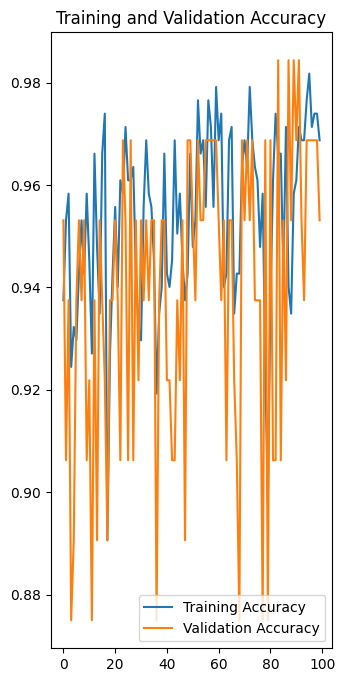

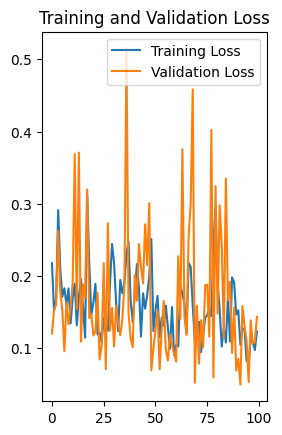

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label="Training Accuracy")
plt.plot(range(EPOCHS), history.history['val_accuracy'], label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['loss'], label="Training Loss")
plt.plot(range(EPOCHS), history.history['val_loss'], label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()

In [32]:
# Predictions from the model
def predict_class(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #Make a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  conf = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, conf


1/1 [==============================] - 0s 28ms/step


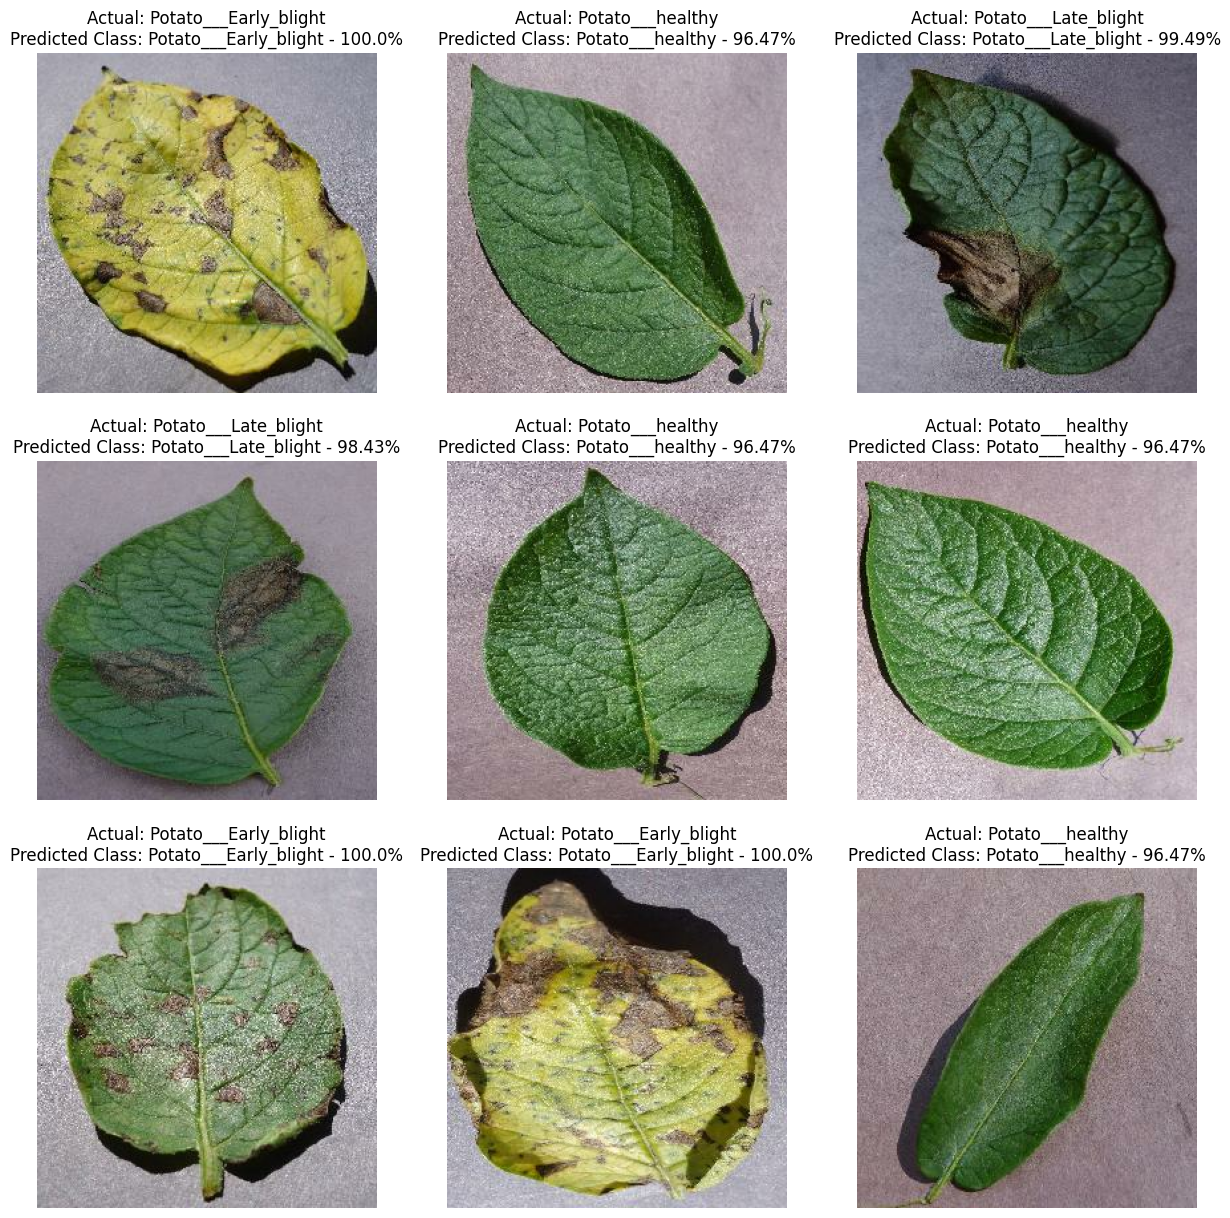

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict_class(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}\nPredicted Class: {predicted_class} - {confidence}%")

    plt.axis('off')

In [35]:
model.save("leaf_disease_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
